In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new
!unzip -qq utkface-new.zip

 99% 329M/331M [00:03<00:00, 126MB/s]
100% 331M/331M [00:03<00:00, 103MB/s]


In [ ]:
!pip install wandb

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import TensorDataset, Dataset
from tqdm import tqdm
import wandb

In [2]:
wandb.init(project="Face Age Regression")

wandb: Currently logged in as: nahid-ebrahimian (use `wandb login --relogin` to force relogin)


### Load and Prepre data

In [3]:
# Hyper Parameters

batch_size = 64
epochs = 20
config = wandb.config
config.learning_rate = 0.001
width = height = 224

In [4]:
images = [] # X
ages = [] # Y

for image_name in os.listdir('crop_part1')[0: 9000]:
    parts = image_name.split('_')
    ages.append(int(parts[0]))
    
    image = cv2.imread(f'crop_part1/{image_name}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

images = pd.Series(images, name='Images')
ages = pd.Series(ages, name='Ages')

df = pd.concat([images, ages], axis=1)
df.head()

,Images,Ages
0,"[[[37, 26, 30], [40, 29, 33], [43, 32, 36], [4...",46
1,"[[[74, 41, 32], [77, 44, 35], [85, 51, 42], [9...",1
2,"[[[40, 30, 28], [38, 28, 26], [35, 25, 23], [3...",8
3,"[[[35, 45, 44], [37, 47, 46], [40, 49, 46], [4...",8
4,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",3


46
(200, 200, 3)


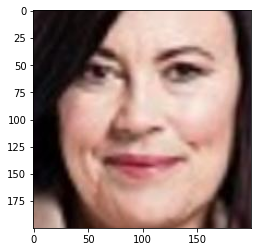

In [5]:
print(df['Ages'][0])
plt.imshow(df['Images'][0])
print(df['Images'][0].shape)

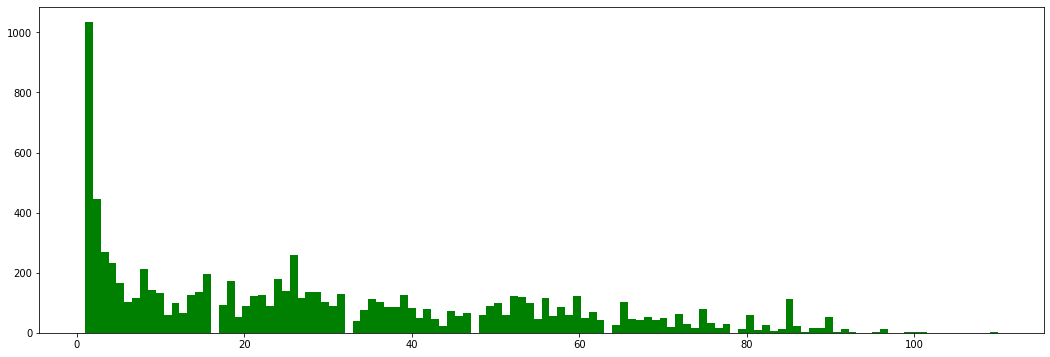

In [6]:
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], bins=116, color='green')
plt.show()

In [7]:
under_4 = []

for i in range(len(df)):
  if df['Ages'].iloc[i] <= 4:
    under_4.append(df.iloc[i])

under_4 = pd.DataFrame(under_4)
under_4 = under_4.sample(frac=0.3)

up_4 = df[df['Ages'] > 4]

df = pd.concat([under_4, up_4])

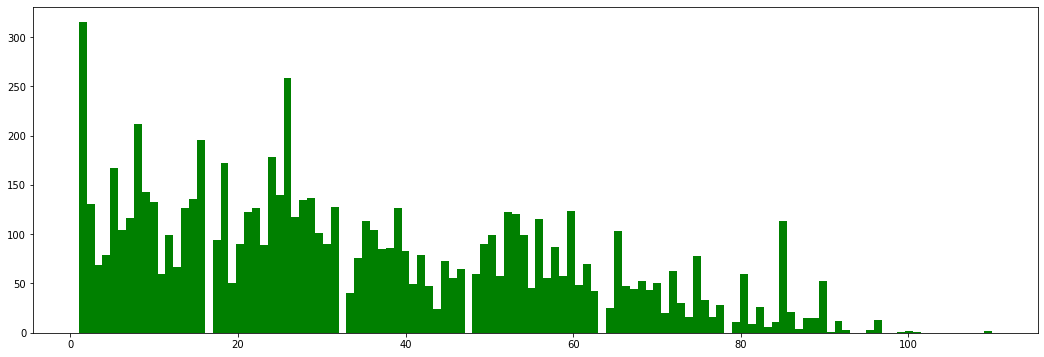

In [8]:
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], bins=116, color='green')
plt.show()

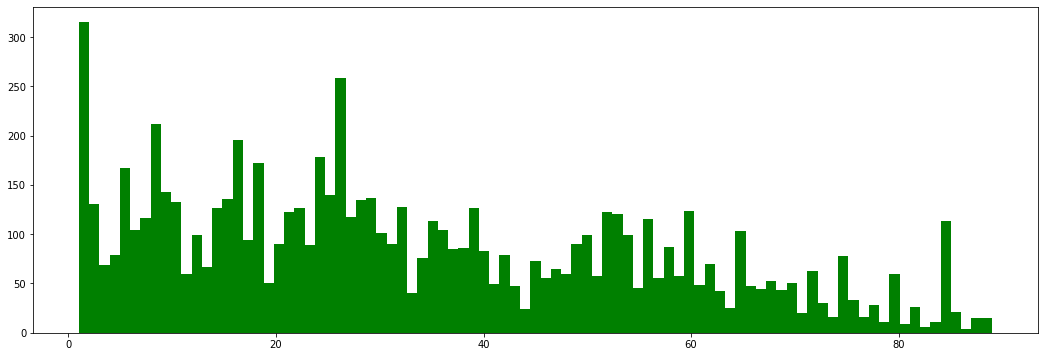

In [9]:
df = df[df['Ages'] < 90]
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], bins=89, color='green')
plt.show()

In [28]:
X = []
Y =[]

for i in range(len(df)):
  df['Images'].iloc[i] = cv2.resize(df['Images'].iloc[i], (width, height))

  X.append(df['Images'].iloc[i])
  Y.append(df['Ages'].iloc[i])

X = np.array(X)
Y = np.array(Y)

X = X.reshape((-1, X.shape[3], X.shape[1], X.shape[2]))
Y = Y.reshape(Y.shape[0], 1)
print(X.shape, Y.shape,X[0].shape)

X = torch.tensor(X)
Y = torch.tensor(Y)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(7523, 3, 224, 224) (7523, 1) (3, 224, 224)


### Transformation

In [33]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform):

        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        y = self.tensors[1][index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)



transform = transforms.Compose([
    torchvision.transforms.ToPILImage(),
    transforms.RandomRotation(10),
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0), (1))
])


train_dataset = CustomTensorDataset(tensors=(X, Y), transform=transform)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

### Train Test Splite

In [35]:
torch.manual_seed(0)

train_dataset_size = int(0.8 * len(train_dataset))
test_dataset_size = len(train_dataset) - train_dataset_size

train_data, _ = torch.utils.data.random_split(train_dataset, [train_dataset_size, test_dataset_size])
train_data = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)


In [23]:
class Model(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, (3, 3), (1, 1), (1, 1)) 
    self.conv2 = nn.Conv2d(32, 64, (3, 3), (1, 1), (1, 1))
    self.conv3 = nn.Conv2d(64, 128, (3, 3), (1, 1), (1, 1))
    self.conv4 = nn.Conv2d(128, 256, (3, 3), (1, 1), (1, 1))
    self.conv5 = nn.Conv2d(256, 512, (3, 3), (1, 1), (1, 1))

    self.fc1 = nn.Linear(512*7*7 ,256)
    self.fc2 = nn.Linear(256 ,128)
    self.fc3 = nn.Linear(128 ,64)
    self.fc4 = nn.Linear(64, 1)

  def forward(self, x):
    conv1 = F.relu(self.conv1(x))
    conv1 = F.max_pool2d(conv1, kernel_size=(2, 2))

    conv2 = F.relu(self.conv2(conv1))
    conv2 = F.max_pool2d(conv2, kernel_size=(2, 2))

    conv3 = F.relu(self.conv3(conv2))
    conv3 = F.max_pool2d(conv3, kernel_size=(2, 2))

    conv4 = F.relu(self.conv4(conv3))
    conv4 = F.max_pool2d(conv4, kernel_size=(2, 2))

    conv5 = F.relu(self.conv5(conv4))
    conv5 = F.max_pool2d(conv5, kernel_size=(2, 2))

    flatten = torch.flatten(conv5, start_dim=1)
    flatten = torch.dropout(flatten, 0.2, train=True)

    fc1 = self.fc1(flatten)
    fc1 = torch.dropout(fc1, 0.2, train=True)

    fc2 = self.fc2(fc1)
    fc2 = torch.dropout(fc2, 0.3, train=True)

    fc3 = self.fc3(fc2)
    fc3 = torch.dropout(fc3, 0.4, train=True)

    output = self.fc4(fc3)
    return output


In [24]:
Model()

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=25088, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)

In [25]:
# args.gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda" if torch.cuda.is_available() and args.gpu else "cpu")
model = Model().to(device)
wandb.watch(model)

[]

In [26]:
# compile

optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
loss_function = nn.L1Loss()

In [36]:
# train

model.train()

for epoch in range(epochs):
  train_loss = 0.0
  train_acc = 0.0
  for images, labels in tqdm(train_data):

    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    images = images.float()
    preds = model(images)

    loss = loss_function(preds,  labels.float())
    loss.backward()

    optimizer.step()

    train_loss += loss

  total_loss = train_loss / len(train_data)
  print(f"Epoch: {epoch+1}, Loss: {total_loss}")

  wandb.log({'epochs':  epoch + 1,
              'loss': total_loss,
                              })

100%|██████████| 95/95 [00:28<00:00,  3.37it/s]


Epoch: 1, Loss: 19.8804874420166


100%|██████████| 95/95 [00:27<00:00,  3.44it/s]


Epoch: 2, Loss: 19.237754821777344


100%|██████████| 95/95 [00:27<00:00,  3.49it/s]


Epoch: 3, Loss: 17.03598403930664


100%|██████████| 95/95 [00:27<00:00,  3.49it/s]


Epoch: 4, Loss: 16.582996368408203


100%|██████████| 95/95 [00:27<00:00,  3.50it/s]


Epoch: 5, Loss: 16.119997024536133


100%|██████████| 95/95 [00:27<00:00,  3.43it/s]


Epoch: 6, Loss: 15.596942901611328


100%|██████████| 95/95 [00:27<00:00,  3.50it/s]


Epoch: 7, Loss: 16.01218032836914


100%|██████████| 95/95 [00:28<00:00,  3.38it/s]


Epoch: 8, Loss: 15.014410018920898


100%|██████████| 95/95 [00:29<00:00,  3.27it/s]


Epoch: 9, Loss: 15.084222793579102


100%|██████████| 95/95 [00:31<00:00,  3.05it/s]


Epoch: 10, Loss: 14.541064262390137


100%|██████████| 95/95 [00:27<00:00,  3.41it/s]


Epoch: 11, Loss: 14.32908821105957


100%|██████████| 95/95 [00:27<00:00,  3.42it/s]


Epoch: 12, Loss: 14.077205657958984


100%|██████████| 95/95 [00:27<00:00,  3.49it/s]


Epoch: 13, Loss: 14.08928394317627


100%|██████████| 95/95 [00:28<00:00,  3.38it/s]


Epoch: 14, Loss: 13.772858619689941


100%|██████████| 95/95 [00:27<00:00,  3.50it/s]


Epoch: 15, Loss: 13.50731086730957


100%|██████████| 95/95 [00:27<00:00,  3.50it/s]


Epoch: 16, Loss: 13.673015594482422


100%|██████████| 95/95 [00:27<00:00,  3.50it/s]


Epoch: 17, Loss: 13.261224746704102


100%|██████████| 95/95 [00:28<00:00,  3.32it/s]


Epoch: 18, Loss: 13.75445556640625


100%|██████████| 95/95 [00:27<00:00,  3.50it/s]


Epoch: 19, Loss: 12.79326343536377


100%|██████████| 95/95 [00:27<00:00,  3.51it/s]

Epoch: 20, Loss: 12.560105323791504


In [37]:
torch.save(model.state_dict(), "age_regression.pth")